In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [3]:
data_train = {}
data_val = {}
data_test = {}
a = 0
b = 0
c = 0
max_len = 0
for j in range(1,4):
    for i in os.listdir('./final_dataset/train/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data_train['%s'%a] = pd.read_csv('./final_dataset/train/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            if len(data_train['%s'%a])/20>max_len:
                max_len=int(len(data_train['%s'%a])/20)
    for i in os.listdir('./final_dataset/validation/%s'%j):
        if i.endswith('.txt'):
            b = b+1
            data_val['%s'%b] = pd.read_csv('./final_dataset/validation/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ') 
    for i in os.listdir('./final_dataset/test/%s'%j):
        if i.endswith('.txt'):
            c = c+1
            data_test['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ') 

In [4]:
max_len

68

## TRAIN SET

In [6]:
a = 0
inputs_train = np.zeros([10,len(data_train),4*max_len])
gt_train = np.zeros([11,len(data_train),4])
in_train_coord = np.zeros([10,len(data_train),2])
gt_train_coord = np.zeros([11,len(data_train),2])

for i in data_train:
    len_d = np.int(len(data_train['%s'%i])/20)
    inputs_train[:,a,:4] = data_train['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data_train['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(20):
                if data_train['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_train[m,a,j*4:(j+1)*4]=data_train['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt_train[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[0:9,['x','y']])
    gt_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()
inputs_train = inputs_train.permute([1,0,2])
gt_train = gt_train.permute([1,0,2])


## VALIDATION SET

In [7]:
a = 0
inputs_validation = np.zeros([10,len(data_val),4*max_len])
gt_validation = np.zeros([11,len(data_val),4])
in_validation_coord = np.zeros([10,len(data_val),2])
gt_validation_coord = np.zeros([11,len(data_val),2])

for i in data_val:
    len_d = np.int(len(data_val['%s'%i])/20)
    inputs_validation[:,a,:4] = data_val['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data_val['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(20):
                if data_val['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_validation[m,a,j*4:(j+1)*4]=data_val['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt_validation[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[0:9,['x','y']])
    gt_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()
inputs_validation = inputs_validation.permute([1,0,2])
gt_validation = gt_validation.permute([1,0,2])


In [8]:
from torch import optim

lr = 0.01
lstm = LSTM(4*max_len,4)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [12]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=32, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=32, shuffle=True)

epochs = 100
steps = 0
print_every = 100
running_loss = 0 #### DOD

for e in range(epochs):
    start = time.time()
    if (e+1)%5==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=0.005)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
                                #+ 10*criterion(out_bis[-1,:,:], targets[-1,:,0:2]) 
                                #+ 10*criterion(out_bis[0,:,:], targets[0,:,0:2]))
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).data[0]

    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    val_loss+= criterion(predicted,valgt).data[0]
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                running_loss = 0
                start = time.time()

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/100.. Validation loss: 1.1849.. Training loss: 7.2260.. 0.0431 s/batch
Epoch: 2/100.. Validation loss: 0.9233.. Training loss: 4.3493.. 0.0134 s/batch
Epoch: 2/100.. Validation loss: 0.8362.. Training loss: 3.4044.. 0.0399 s/batch
Epoch: 3/100.. Validation loss: 0.7671.. Training loss: 2.9735.. 0.0264 s/batch
Epoch: 4/100.. Validation loss: 0.7459.. Training loss: 2.8526.. 0.0049 s/batch
Epoch: 4/100.. Validation loss: 0.7300.. Training loss: 2.6448.. 0.0391 s/batch
Epoch: 5/100.. Validation loss: 0.7189.. Training loss: 2.6483.. 0.0185 s/batch
Epoch: 5/100.. Validation loss: 0.7078.. Training loss: 2.5669.. 0.0378 s/batch
Epoch: 6/100.. Validation loss: 0.7047.. Training loss: 2.5065.. 0.0334 s/batch
Epoch: 7/100.. Validation loss: 0.7013.. Training loss: 2.5308.. 0.0100 s/batch
Epoch: 7/100.. Validation loss: 0.6924.. Training loss: 2.4266.. 0.0388 s/batch
Epoch: 8/100.. Validation loss: 0.6863.. Training loss: 2.4259.. 0.0270 s/batch
Epoch: 9/100.. Validation loss: 0.6772..

Epoch: 64/100.. Validation loss: 0.5212.. Training loss: 1.4023.. 0.0337 s/batch
Epoch: 65/100.. Validation loss: 0.5367.. Training loss: 1.4032.. 0.0110 s/batch


KeyboardInterrupt: 

In [13]:
inputs_pred = inputs_train.permute([1,0,2])
output_final = lstm.predict(inputs_pred)
output_final = output_final.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [14]:
output_final.shape

(10, 5157, 4)

In [17]:
output_coord=np.zeros([11,len(data_train),2])
for j in range(11):
    for i in range(len(data_train)):
        if j==0:
            output_coord[j,i,0:2] = in_train_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_coord[j-1,i,0:2]+output_final[j-1,i,2:]*0.4
        

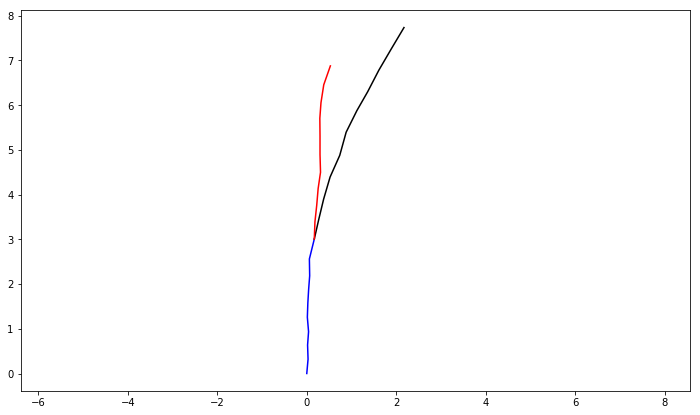

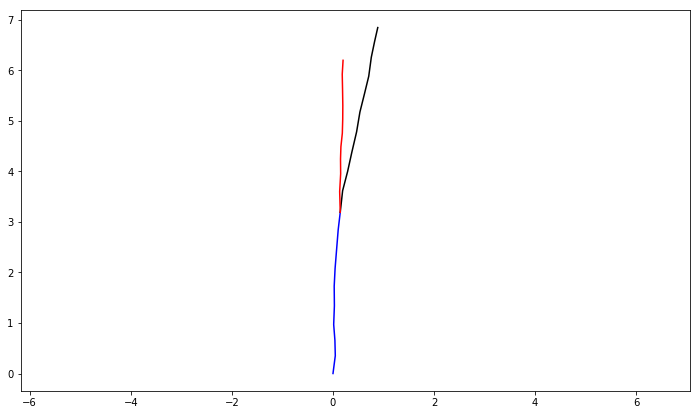

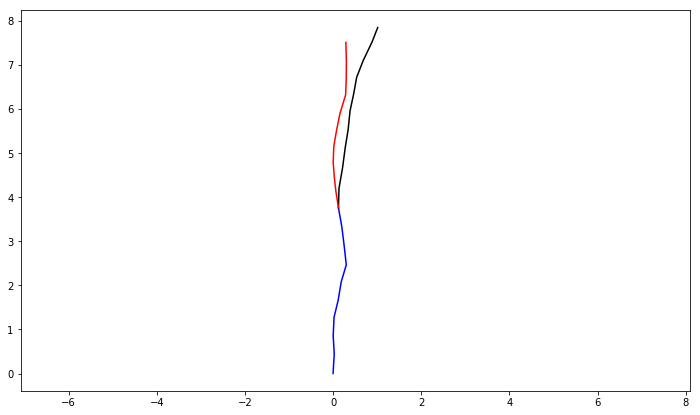

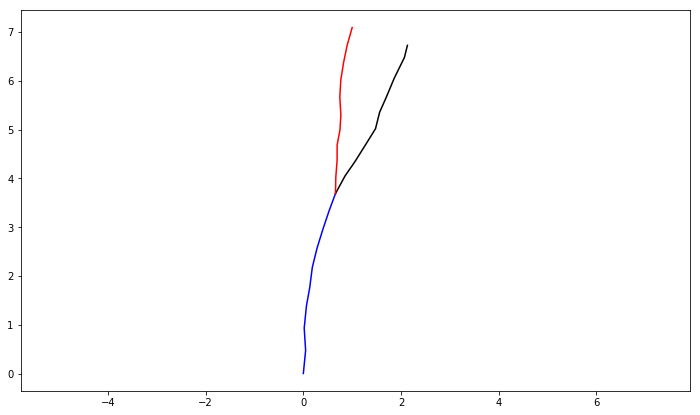

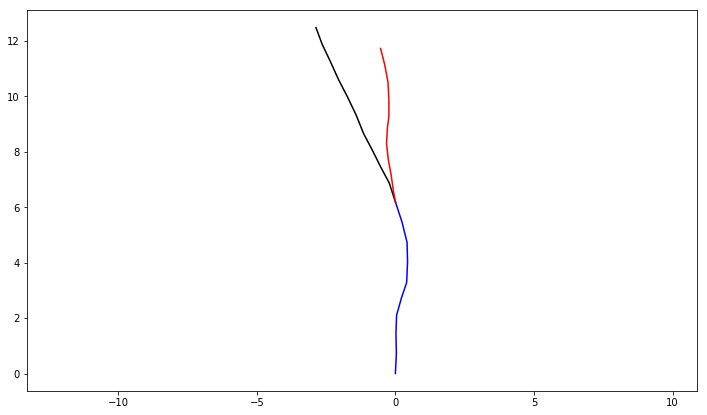

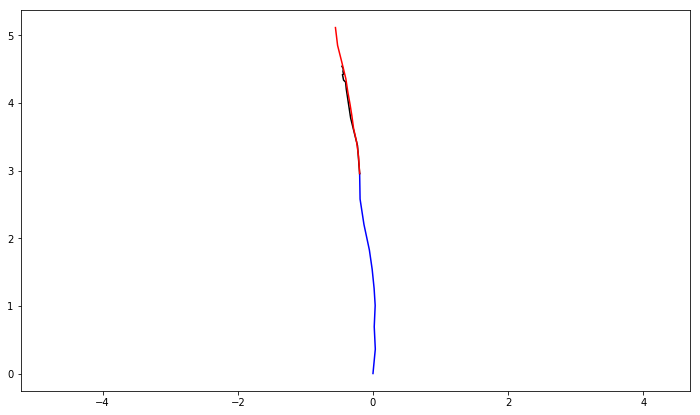

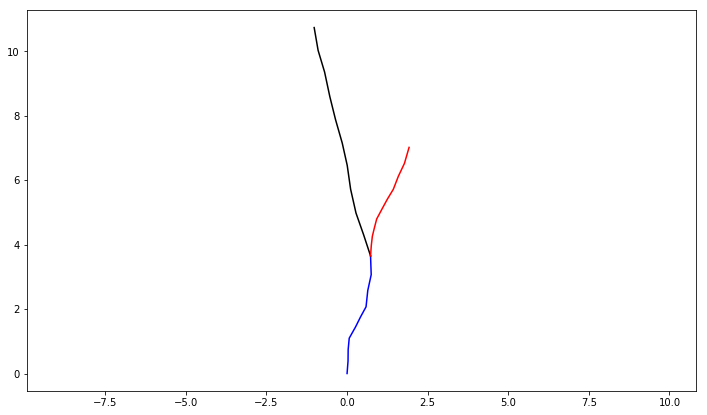

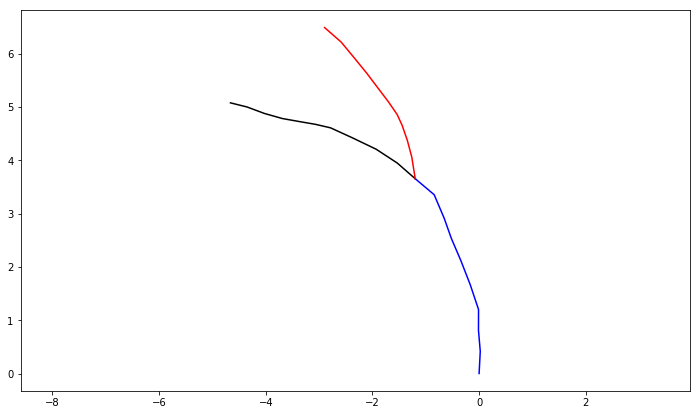

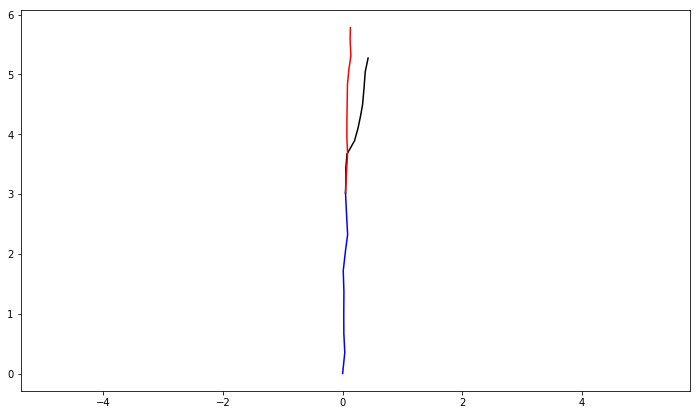

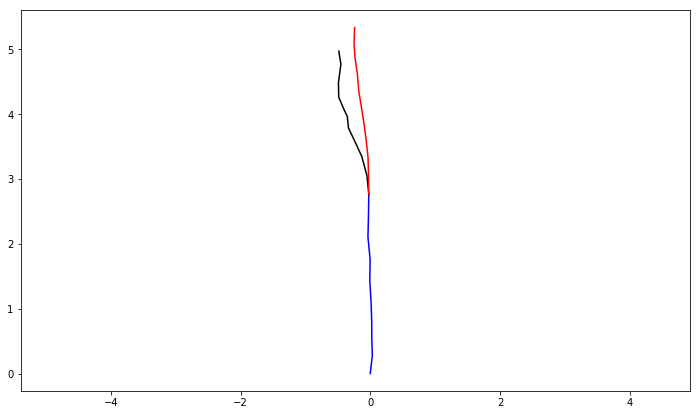

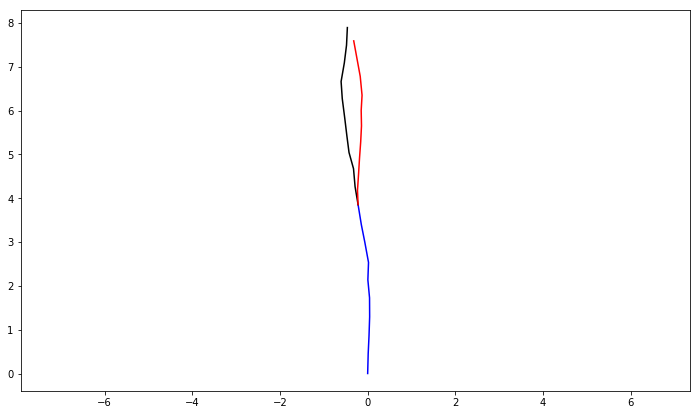

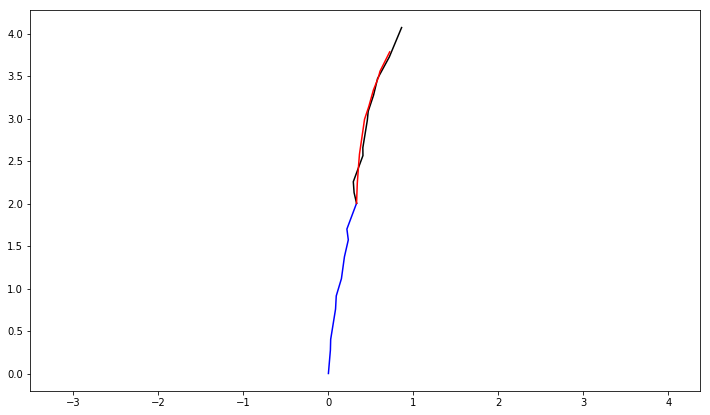

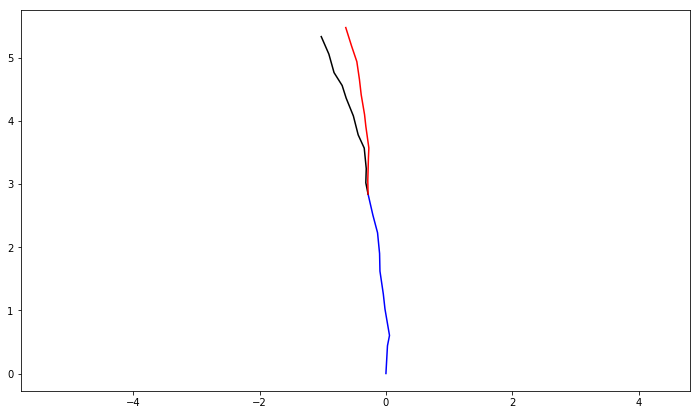

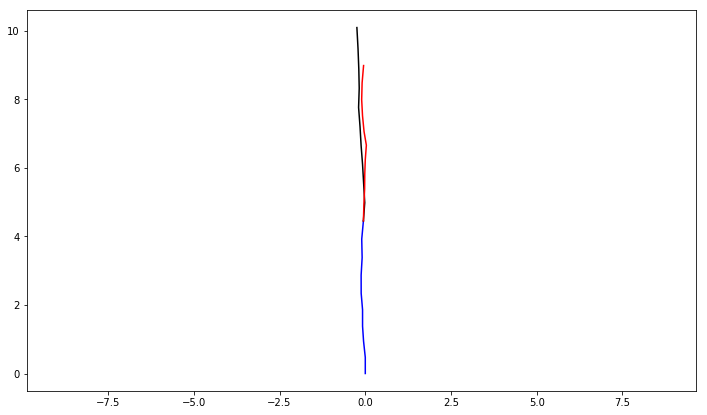

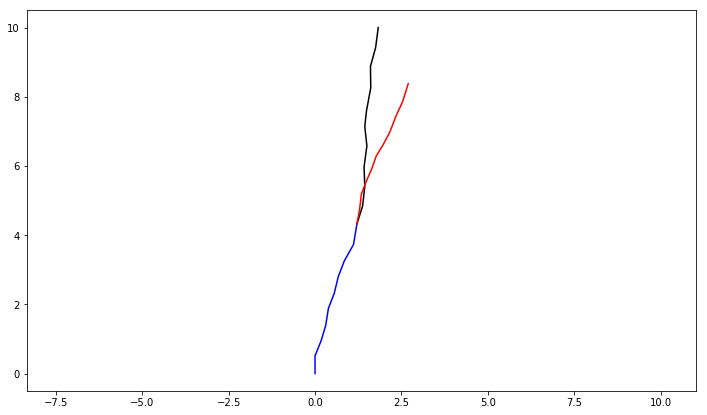

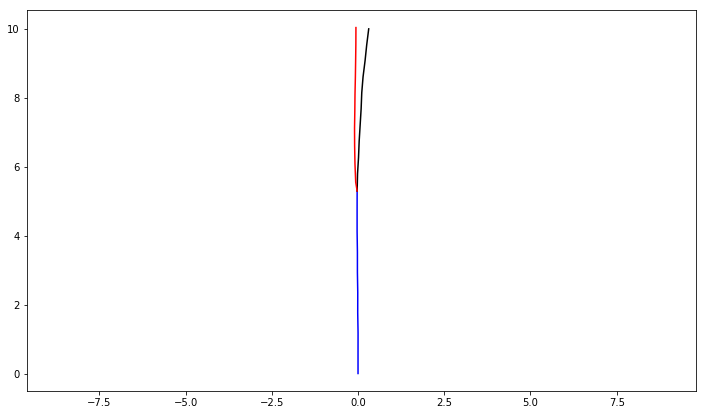

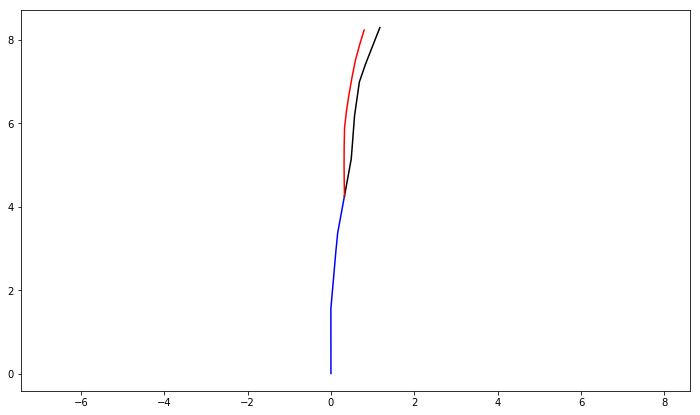

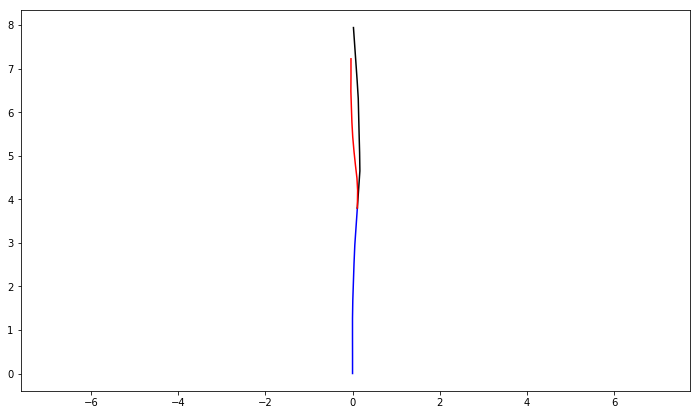

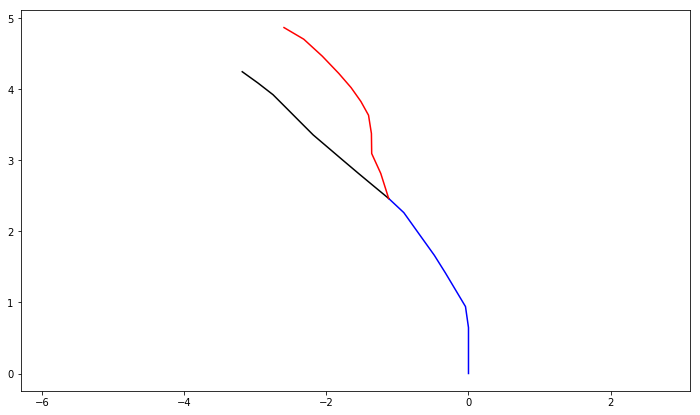

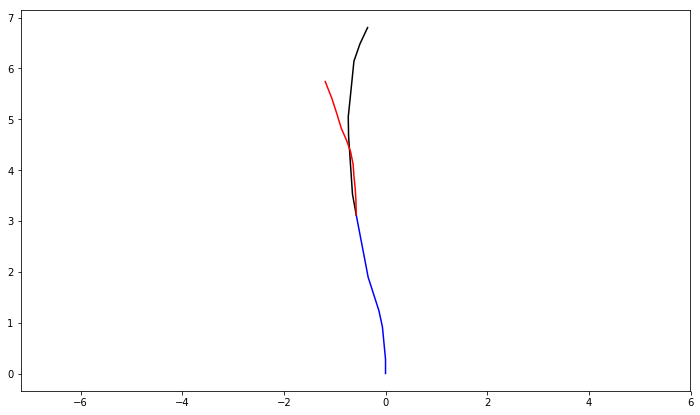

In [18]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_train_coord[:,(i*20)+2000,0],in_train_coord[:,i*20+2000,1],c='b')
    plt.plot(gt_train_coord[:,i*20+2000,0],gt_train_coord[:,i*20+2000,1],c='k')
    plt.plot(output_coord[:,i*20+2000,0],output_coord[:,i*20+2000,1],c='r')
    plt.axis('equal')

In [ ]:
sum(sum(sum(inputs_train>0)))

In [ ]:
inputs_train.shape

In [ ]:
4*max_len